In [120]:
# %pip install pmdarima

In [121]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima as pm
dict_df = pd.read_excel("../../Data/Monthly_retail_sales_workbook.xlsx", skiprows= 4, sheet_name = None)

Get the information on the produced dictionary. Subcode

In [122]:
#currently reads in all sheets to a dictionary of dataframes without names
# print(type(dict_df))
# print(len(dict_df))
# for key in dict_df:
#     print(key)

Create a single dataframe from dictionary to work with as an example
This cleans the top and bottom of the dataframe of unwanted data.
Subcode

In [123]:
# df = dict_df.get('1992')
# df = df.drop(['TOTAL'], axis = 1)
# df = df.drop([0])
# df.rename(columns = {'Unnamed: 0':'NAICScode', 'Unnamed: 1':'NAICSname'}, inplace = True)
# print(type(df['NAICSCode']))
# drop_rows = df[df['NAICSCode'] == 722].index.tolist()[1]
# df = df.iloc[:drop_rows-1] #This drops the bottom rows that are not needed if i can locate the second index

This splits the single dataframe into two separate dataframes for adjusted and non adjusted values.
It also removed the last of unwanted data that includes combination values and additional top bottom values
I tried removing rows that had a comma in them based on NAICSCode, but that crashed the kernel and was far more time consuming then necessary.
Subcode

In [124]:
# adjusted_indexlist = df[df['NAICSname'] == 'ADJUSTED(2)'].index.tolist()[0]
# adjusted_df = df.iloc[adjusted_indexlist+7:,:]
# adjusted_df = adjusted_df.drop([75, 77])
# non_adjusteddf = df.iloc[:adjusted_indexlist -6,:]
# number_of_rows = 7
# non_adjusteddf = non_adjusteddf.iloc[number_of_rows: , :]
# non_adjusteddf = non_adjusteddf.drop([9, 14])
# #at this point the dataframes are split and done.  They need writing to new dictionaries
# display(non_adjusteddf)
# display(adjusted_df)

One thing to note is that that the dataframes need to be pivoted for the ml algorithm and that the code will likely need to be removed for that step as well or at least moved.

This should be the full automation to run through the entire dictionary clean and write the dataframes into new dictionaries.  It is the combination of the above codes int a for loop.

It also flips each dataframe to get the date order sequentially from earliest to latest top to bottom

keys are nonadjusted_year or adjusted_year.  year refers to the dictionary key.

In [125]:
# adjusted_dict = {}
# nonadjusted_dict = {}
# for key in dict_df:
#     if key == '2022':
#         print('Skipping 2022 due to incomplete data')
#     else:
#         df = dict_df.get('{}'.format(key))
#         df = df.drop(['TOTAL'], axis = 1)
#         df = df.drop([0])
#         df.rename(columns = {'Unnamed: 0':'NAICScode', 'Unnamed: 1':'NAICSname'}, inplace = True)
#         drop_rows = df[df['NAICScode'] == 722].index.tolist()[1] #chooses the second occurence of 722
#         df = df.iloc[:drop_rows-1]
#         # code for bottom section adjusted dataframe
#         adjusted_indexlist = df[df['NAICSname'] == 'ADJUSTED(2)'].index.tolist()[0]
#         adjusted_df = df.iloc[adjusted_indexlist+7:,:]
#         adjusted_df = adjusted_df.drop([75, 77])
#         #code for top, non adjusted dataframe
#         non_adjusteddf = df.iloc[:adjusted_indexlist -6,:]
#         number_of_rows = 7
#         non_adjusteddf = non_adjusteddf.iloc[number_of_rows: , :]
#         non_adjusteddf = non_adjusteddf.drop([9, 14])
#         #Write dataframes to new dictionaries
#         adjusted_dict.update({'adjusted_{}'.format(key) : adjusted_df})
#         nonadjusted_dict.update({'nonadjusted_{}'.format(key): non_adjusteddf})

This is the exact same as above, but it keeps the total retail sales rows in both frame sets.  
If necessary.
This is the basis for the dataframes and the most basic cleaning.

In [126]:
adjusted_dict = {}
nonadjusted_dict = {}
for key in dict_df:
    if key == '2022':
        print('Skipping 2022 due to incomplete data')
    else:
        df = dict_df.get('{}'.format(key))
        df = df.drop(['TOTAL'], axis = 1)
        df = df.drop([0])
        df.rename(columns = {'Unnamed: 0':'NAICScode', 'Unnamed: 1':'NAICSname'}, inplace = True)
        drop_rows = df[df['NAICScode'] == 722].index.tolist()[1] #chooses the second occurence of 722
        df = df.iloc[:drop_rows-1]
        # code for bottom section adjusted dataframe
        adjusted_indexlist = df[df['NAICSname'] == 'ADJUSTED(2)'].index.tolist()[0]
        adjusted_df = df.iloc[adjusted_indexlist+4:,:]
        adjusted_df = adjusted_df.drop([72,73, 75, 77])
        #code for top, non adjusted dataframe
        non_adjusteddf = df.iloc[:adjusted_indexlist -6,:]
        non_adjusteddf = non_adjusteddf.iloc[4: , :]
        non_adjusteddf = non_adjusteddf.drop([6,7,9,14])
        #Write dataframes to new dictionaries
        adjusted_dict.update({'adjusted_{}'.format(key) : adjusted_df})
        nonadjusted_dict.update({'nonadjusted_{}'.format(key): non_adjusteddf})

Skipping 2022 due to incomplete data


The below code takes out the header and splits it into a list of month and year.  
It then converts the month into the integer representation.
It needs to be looped or added to the loop based on what we need.
The 'Total''s were left to represent the unmodified version of the table.
Subcode

In [127]:
# dict_df2 = pd.read_excel("Monthly_retail_sales_workbook.xlsx", header = None, skiprows= 4, sheet_name = None)
# df2 = dict_df2.get('1992')
# daterowsplit = df2.iloc[0]
# daterowsplit = daterowsplit.drop([0,1,14])
# daylist = []
# yearlist = []
# for i in daterowsplit:
#     if type(i) == str:
#         if i.find('.') != -1:
#             x = i.split('. ')
#         else:
#             x = i.split(' ')
#     if x[0] != 'TOTAL':
#         x[0] = datetime.strptime(x[0], '%b').month
#     daylist.append(x[0])
#     yearlist.append(x[1])
# print(daylist)
# print(yearlist)
    

This will take the dataframes and using the melt method make the data header a column associated with each value so that it can be loaded according to our ERD into the database

In [128]:
new_adjusted_dict_for_database = {}
new_nonadjusted_dict_for_database = {}
for i in adjusted_dict:
    df5 = adjusted_dict[i]
    df5 = adjusted_dict[i].melt(id_vars=["NAICScode", "NAICSname"], var_name="Date", value_name="Adjusted Sales")
    datecolumn = df5['Date']
    daylist = []
    yearlist = []
    for i in datecolumn:
        if type(i) == str:
            if i.find('.') != -1:
                x = i.split('. ')
            else:
                x = i.split(' ')
        if x[0] != 'TOTAL':
            x[0] = datetime.strptime(x[0], '%b').month
        daylist.append(x[0])
        yearlist.append(x[1])

    df5.insert(0,'Month', daylist)
    df5.insert(0,'Year', yearlist)
    df5 = df5.drop(labels=['Date', "NAICSname"], axis=1)
    new_adjusted_dict_for_database[i] = df5

for i in nonadjusted_dict:
    df5 = nonadjusted_dict[i]
    df5 = nonadjusted_dict[i].melt(id_vars=["NAICScode", "NAICSname"], var_name="Date", value_name="Unadjusted Sales")
    datecolumn = df5['Date']
    daylist = []
    yearlist = []
    for i in datecolumn:
        if type(i) == str:
            if i.find('.') != -1:
                x = i.split('. ')
            else:
                x = i.split(' ')
        if x[0] != 'TOTAL':
            x[0] = datetime.strptime(x[0], '%b').month
        daylist.append(x[0])
        yearlist.append(x[1])

    df5.insert(0,'Month', daylist)
    df5.insert(0,'Year', yearlist)
    df5 = df5.drop(labels=['Date', "NAICSname"], axis=1)
    new_nonadjusted_dict_for_database[i] = df5

Write the melted dataframes to superframes or frames composed of all data from the adjusted or non adjusted dictionaries for all years. then one composed dataframe of all data joined on Year and month.

In [129]:
adjusted_superframe_for_database = pd.concat(new_adjusted_dict_for_database, ignore_index=True)
nonadjusted_superframe_for_database = pd.concat(new_nonadjusted_dict_for_database, ignore_index=True)
adjusted_superframe_for_database = adjusted_superframe_for_database.apply(pd.to_numeric, errors='coerce')
nonadjusted_superframe_for_database = nonadjusted_superframe_for_database.apply(pd.to_numeric, errors='coerce')
THESUPERFRAME = nonadjusted_superframe_for_database.merge(adjusted_superframe_for_database, left_on=('Year','Month','NAICScode'),right_on=('Year','Month','NAICScode'))

This transposes the dataframes that are in the respective dictionaries, splits the date column into month and year.
It then writes the value to a new dictionary.
The starting point for this code is after basic cleaning located in code box 6.

In [130]:
new_adjusted_dict = {}
new_nonadjusted_dict = {}
for i in adjusted_dict:
    df4 = adjusted_dict[i]
    df4 = df4.transpose()
    df4.columns = df4.iloc[1]
    df4 = df4.drop(index=['NAICSname', 'NAICScode'])
    df4 = df4.iloc[::-1]
    new_adjusted_dict[i] = df4

for i in nonadjusted_dict:
    df4 = nonadjusted_dict[i]
    df4 = df4.transpose()
    df4.columns = df4.iloc[1]
    df4 = df4.drop(index=['NAICSname', 'NAICScode'])
    df4 = df4.iloc[::-1]
    new_nonadjusted_dict[i] = df4

Gavan Especial.  Frames are non-indexed by the date and month and year are a separate columns.
This uses the dictionary created in the code box above as the base.
It only splits and separates the adjusted data frame for our purposes.
Code can be easily duplicated for non adjusted since they are in identical structure.

In [131]:
#bring all dataframes from respective dictionaries into one SUPERFRAME!!!
from tokenize import Triple

adjusted_superframe = pd.concat(new_adjusted_dict, ignore_index=False)
nonadjusted_superframe = pd.concat(new_nonadjusted_dict, ignore_index=False) #this may need to be converted back to True
#convert all information into numerics and null non-converted values
adjusted_superframe = adjusted_superframe.apply(pd.to_numeric, errors='coerce')
nonadjusted_superframe = nonadjusted_superframe.apply(pd.to_numeric, errors='coerce')
# drop the dictionary name from the multilevel index
adjusted_superframe = adjusted_superframe.droplevel(level=0)
nonadjusted_superframe = nonadjusted_superframe.droplevel(level=0)
#invert the dataframe to have it in correct sequential order
adjusted_superframe = adjusted_superframe.iloc[::-1]
nonadjusted_superframe = nonadjusted_superframe.iloc[::-1]
daylist = []
yearlist = []
for i in adjusted_superframe.index:
    if type(i) == str:
        if i.find('.') != -1:
            x = i.split('. ')
        else:
            x = i.split(' ')
    if x[0] != 'TOTAL':
        x[0] = datetime.strptime(x[0], '%b').month
    daylist.append(x[0])
    yearlist.append(x[1])

adjusted_superframe_with_monthyear = pd.DataFrame()
adjusted_superframe_with_monthyear.insert(0,'Month', daylist)
adjusted_superframe_with_monthyear.insert(0,'Year', yearlist)


This tranforms the index containing the date to datetime type for Ml.
It contains base code commented out for different visuals and a correlation matrix

In [132]:
#This will change the index to datetime.
nonadjusted_superframe.index = pd.to_datetime(nonadjusted_superframe.index)
adjusted_superframe.index = pd.to_datetime(nonadjusted_superframe.index)
# use to plot a specific column from either frame
# plt.figure(figsize=(20,16))
# plot = plt.plot(adjusted_superframe['Retail sales, total'])
# the code below displays the frames or the correlation matrix associated with the frame
# display(adjusted_superframe)
# adjusted_correlation_matrix = adjusted_superframe.corr()
# adjusted_correlation_matrix

The Machine learning begins.  Bum Bum Bum. Auto Arima machine learning

Check for null Values in the dataframe.
Print out columns with null values.

In [133]:
print ("\nMissing values :  ", adjusted_superframe.isnull().any())


Missing values :   NAICSname
Retail sales, total                                           False
Motor vehicle and parts dealers                               False
Automotive parts, acc., and tire stores                       False
Furniture and home furnishings stores                         False
Electronics and appliance stores                              False
Building mat. and garden equip. and supplies dealers          False
Building mat. and supplies dealers                            False
Food and beverage stores                                      False
Grocery stores                                                False
Beer, wine and liquor stores                                  False
Health and personal care stores                               False
Pharmacies and drug stores                                    False
Gasoline stations                                             False
Clothing and clothing access. stores                          False
Clothing stores   

Impute null values and check agian.

In [134]:
#in case we want nonadjusted this loop could also be used for adjusted with modification
# for t in nonadjusted_superframe:
#     if nonadjusted_superframe[t].isnull().any():
#         nonadjusted_superframe[t] = nonadjusted_superframe[t].fillna(method='bfill')

adjusted_superframe['Jewelry stores'] = adjusted_superframe['Jewelry stores'].fillna(method='ffill')
adjusted_superframe['Men\'s clothing stores'] = adjusted_superframe['Men\'s clothing stores'].fillna(method='ffill')
print ("\nMissing values :  ", adjusted_superframe.isnull().any())



Missing values :   NAICSname
Retail sales, total                                           False
Motor vehicle and parts dealers                               False
Automotive parts, acc., and tire stores                       False
Furniture and home furnishings stores                         False
Electronics and appliance stores                              False
Building mat. and garden equip. and supplies dealers          False
Building mat. and supplies dealers                            False
Food and beverage stores                                      False
Grocery stores                                                False
Beer, wine and liquor stores                                  False
Health and personal care stores                               False
Pharmacies and drug stores                                    False
Gasoline stations                                             False
Clothing and clothing access. stores                          False
Clothing stores   

    Create the model using the automated method to find hyperparameters.
    d=1 defines that is not stationary data.

In [135]:
#data is non stationary.
#gridsearch instead of stepwise was selected and tracing or approximations were declined.
model = pm.auto_arima(adjusted_superframe['Retail sales, total'], 
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',
                           suppress_warnings=True,
                      stepwise=False, trace=False)    

#define mean absolute percentage error
def MAPE(Y_actual,Y_Predicted):
     mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
     return mape              

Split the data into separate groupings for training and testing

In [136]:
#non differenced set
train=adjusted_superframe[(adjusted_superframe.index.get_level_values(0) >= '1992-01-01') & (adjusted_superframe.index.get_level_values(0) <= '2021-05-01')]
test=adjusted_superframe[(adjusted_superframe.index.get_level_values(0) > '2021-05-01')]

Create a model on the training data with the dependent variable being total retail sales.
Show the predicted values for the last seven months of 2021.

In [137]:
#regular
model.fit(train['Retail sales, total'])
forecast=model.predict(n_periods=7, return_conf_int=True)
forecast

(array([550440.17865226, 551331.71611198, 552564.2612499 , 553278.81765516,
        554749.84407457, 556349.26153716, 557566.68619865]),
 array([[537422.12501373, 563458.23229079],
        [533381.6191405 , 569281.81308347],
        [531165.39059821, 573963.13190159],
        [528879.29930806, 577678.33600225],
        [527664.34459349, 581835.34355564],
        [526823.5165184 , 585875.00655591],
        [525788.18901865, 589345.18337865]]))

transform it into a dataframe with column predictions

In [138]:
forecast_df = pd.DataFrame(forecast[0],index = test.index,columns=['Prediction'])
forecast_df

,Prediction
2021-06-01,550440.178652
2021-07-01,551331.716112
2021-08-01,552564.261250
2021-09-01,553278.817655
2021-10-01,554749.844075
2021-11-01,556349.261537
2021-12-01,557566.686199


plot all retail sales data against the predicted value.

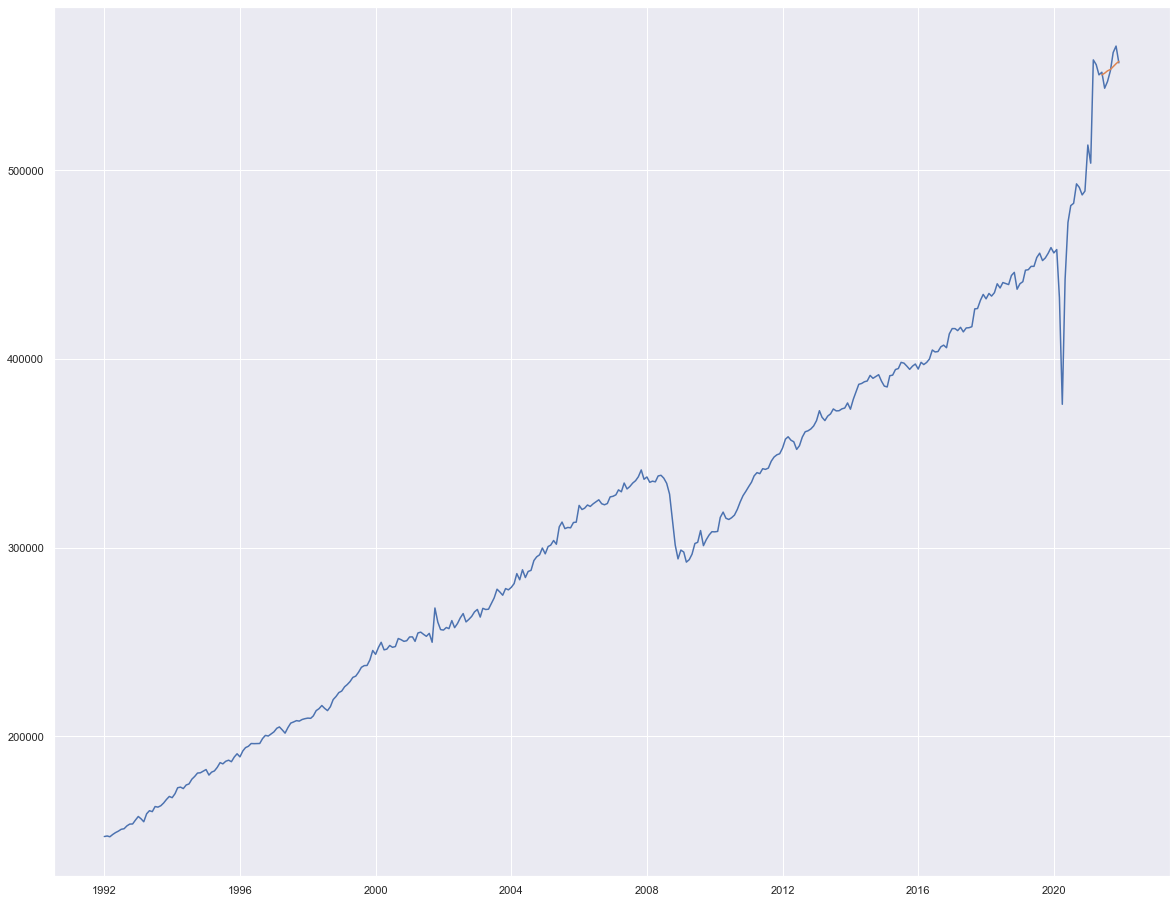

In [139]:
plt.figure(figsize=(20,16))
plot = pd.concat([adjusted_superframe['Retail sales, total'],forecast_df],axis=1)
subplot = pd.concat([adjusted_superframe['Retail sales, total'].tail(n=7),forecast_df],axis=1)
plt.plot(plot)

same plot focused on the overlapping data of predicted and actual values

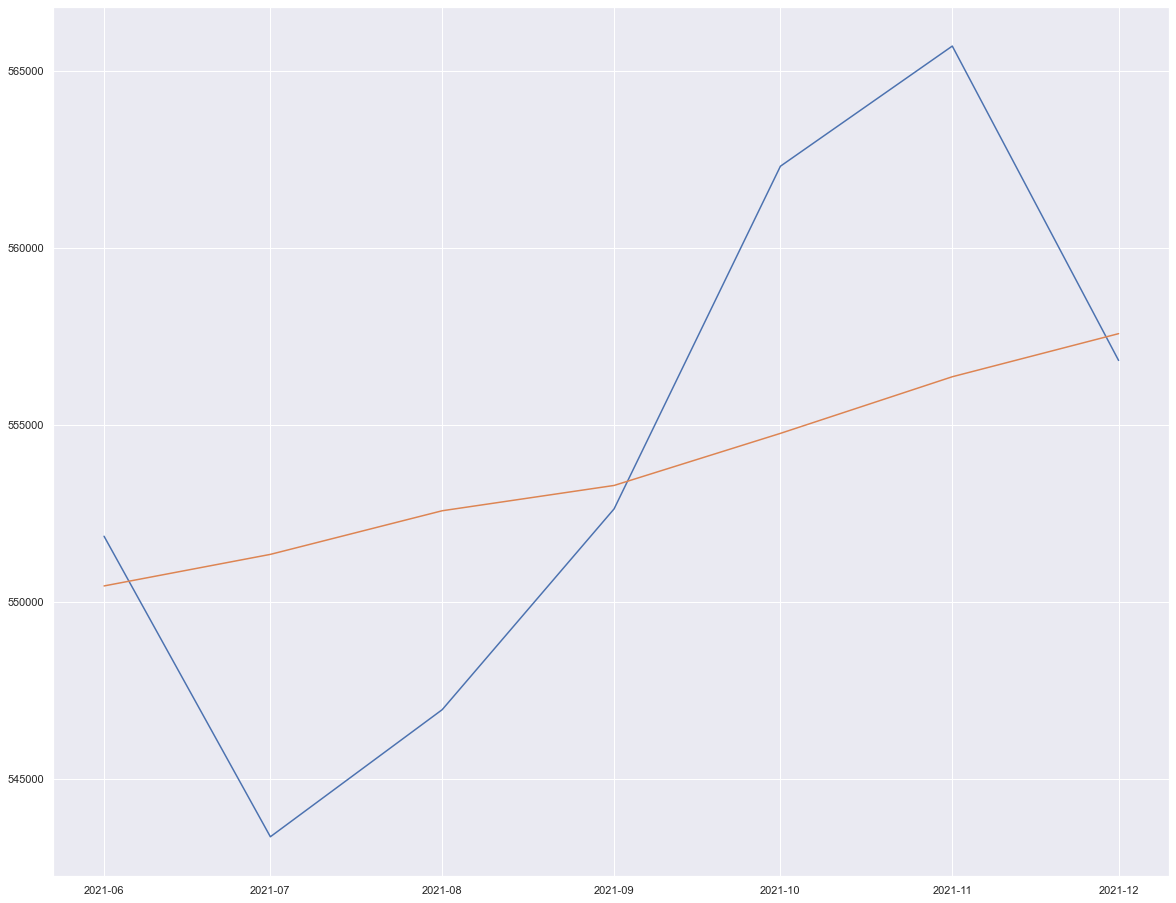

In [140]:
plt.figure(figsize=(20,16))
plt.plot(subplot)

In [141]:
extended_forecast_non_stationary = model.predict(n=10, return_conf_int=True)
# extended_forecast
dates = ['2022-01-01','2022-02-01','2022-03-01']#, '2022-04-01','2022-05-01','2022-06-01'
date_in_datetime = []
for i in dates:
    date_in_datetime.append(datetime.strptime(i, '%Y-%m-%d'))
    
extended_index = pd.Index(date_in_datetime)
new_index = test.index.append(extended_index)
# print(new_index)
extended_forecast_df_non_stationary = pd.DataFrame(extended_forecast_non_stationary[0],index = new_index,columns=['Prediction'])
display(extended_forecast_df_non_stationary)

,Prediction
2021-06-01,550440.178652
2021-07-01,551331.716112
2021-08-01,552564.261250
2021-09-01,553278.817655
2021-10-01,554749.844075
2021-11-01,556349.261537
2021-12-01,557566.686199
2022-01-01,557388.850225
2022-02-01,559347.463328
2022-03-01,557338.877833


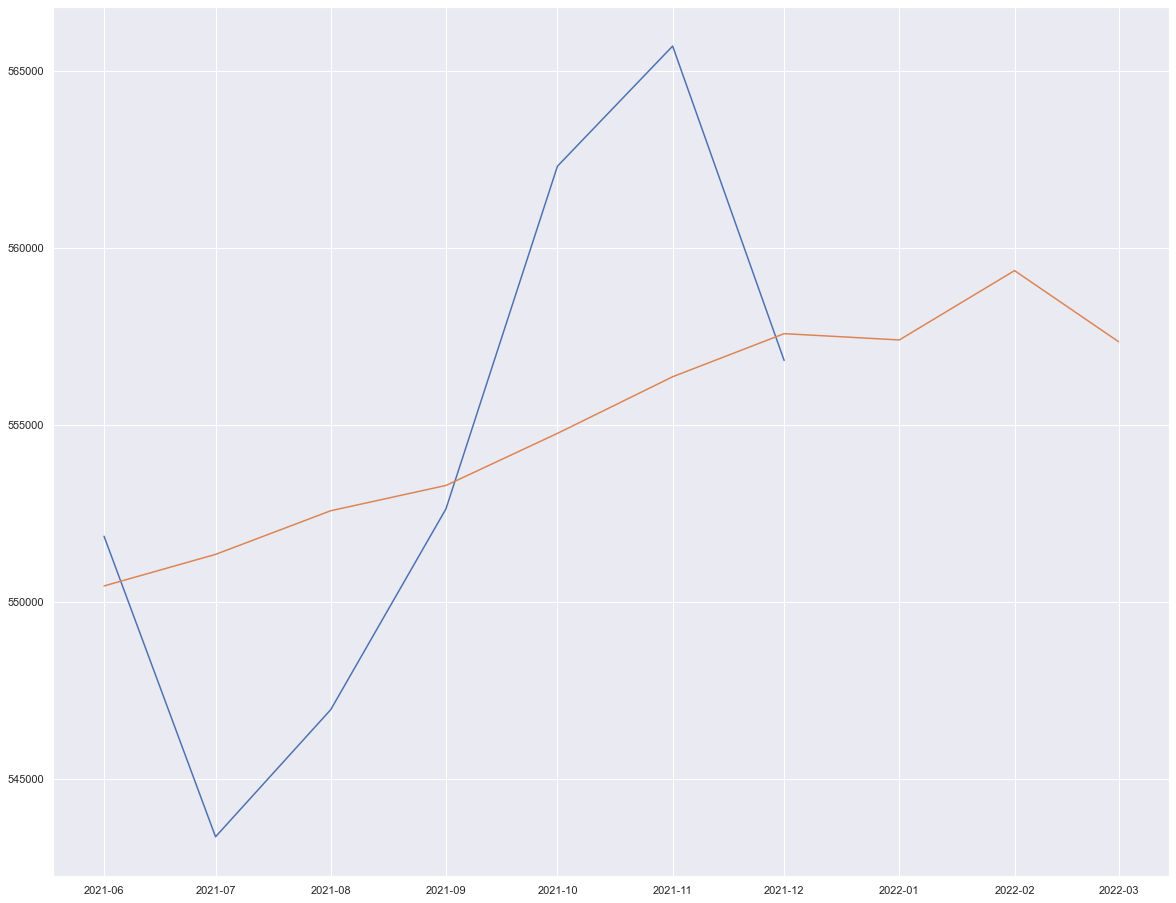

In [142]:
# baseplot = plt.plot
extended_subplot_non_stationary = pd.concat([adjusted_superframe['Retail sales, total'].tail(n=7),extended_forecast_df_non_stationary])
plt.figure(figsize=(20,16))
plt.plot(extended_subplot_non_stationary)

In [143]:
extended_forecast_df_non_stationary.to_csv('../../Data/MLData.csv')

In [68]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  353
Model:             SARIMAX(2, 1, 0)x(0, 0, [1], 12)   Log Likelihood               -3597.083
Date:                              Wed, 17 Aug 2022   AIC                           7204.166
Time:                                      16:04:36   BIC                           7223.484
Sample:                                           0   HQIC                          7211.854
                                              - 353                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1407.7078    397.816      3.539      0.000     628.003    2187.412
ar.L1         -0.0507      0.012     -4.375      0.000      -0.073      -0.028
ar.L2         -0.0571      0.017     -3.427      0.001      -0.090      -0.024
ma.S.L12      -0.0633      0.025     -2.547      0.011      -0.112      -0.015
sigma2      4.412e+07      0.002   2.14e+10      0.000    4.41e+07    4.41e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):             34539.51
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):              17.73   Skew:                             1.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        51.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.94e+26. Standard errors may be unstable.
"""

In [69]:
actuallist = adjusted_superframe['Retail sales, total'].tail(n=7).to_list()
actuallist
print(MAPE(actuallist,forecast[0]))
mae = mean_absolute_error(actuallist, forecast[0])
print(mae)

0.8569337533970193
4757.742421672597


This is the differenced version of the same model

In [70]:
adjusted_superframe['Retail sales, total'] = adjusted_superframe['Retail sales, total'] - adjusted_superframe['Retail sales, total'].shift(1)

adjusted_superframe['Retail sales, total'] = adjusted_superframe['Retail sales, total'].fillna(method='bfill')

display(adjusted_superframe['Retail sales, total'])


1992-01-01     298.0
1992-02-01     298.0
1992-03-01    -418.0
1992-04-01    1227.0
1992-05-01     978.0
               ...  
2021-08-01    3591.0
2021-09-01    5671.0
2021-10-01    9679.0
2021-11-01    3394.0
2021-12-01   -8880.0
Name: Retail sales, total, Length: 360, dtype: float64

In [71]:
model = pm.auto_arima(adjusted_superframe['Retail sales, total'], 
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',
                           suppress_warnings=True,
                      stepwise=False, trace=False)

train=adjusted_superframe[(adjusted_superframe.index.get_level_values(0) >= '1992-01-01') & (adjusted_superframe.index.get_level_values(0) <= '2021-05-01')]
test=adjusted_superframe[(adjusted_superframe.index.get_level_values(0) > '2021-05-01')]

model.fit(train['Retail sales, total'])
forecast=model.predict(n_periods=7, return_conf_int=True)
forecast_df = pd.DataFrame(forecast[0],index = test.index,columns=['Prediction'])


In [72]:

extended_forecast = model.predict(n=10, return_conf_int=True)
# extended_forecast
dates = ['2022-01-01','2022-02-01','2022-03-01']#, '2022-04-01','2022-05-01','2022-06-01'
date_in_datetime = []
for i in dates:
    date_in_datetime.append(datetime.strptime(i, '%Y-%m-%d'))
    
extended_index = pd.Index(date_in_datetime)
new_index = test.index.append(extended_index)
# print(new_index)
extended_forecast_df = pd.DataFrame(extended_forecast[0],index = new_index,columns=['Prediction'])
display(extended_forecast_df)

,Prediction
2021-06-01,-5213.019306
2021-07-01,-1191.369535
2021-08-01,1217.337510
2021-09-01,-608.878464
2021-10-01,1839.541169
2021-11-01,2265.396969
2021-12-01,1052.340997
2022-01-01,-3439.342398
2022-02-01,3396.055169
2022-03-01,-9533.963903


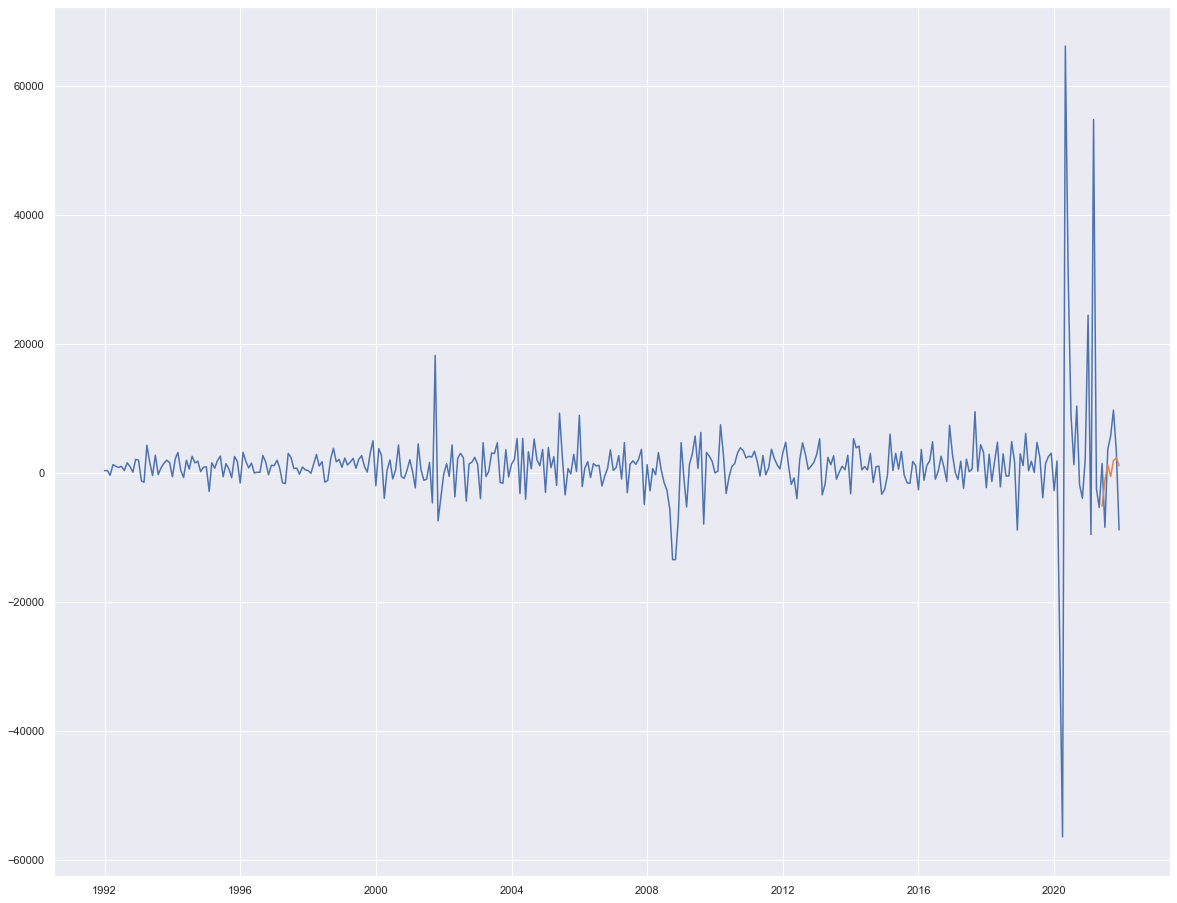

In [73]:
plt.figure(figsize=(20,16))
plot = pd.concat([adjusted_superframe['Retail sales, total'],forecast_df],axis=1)
subplot = pd.concat([adjusted_superframe['Retail sales, total'].tail(n=7),forecast_df],axis=1)
plt.plot(plot)

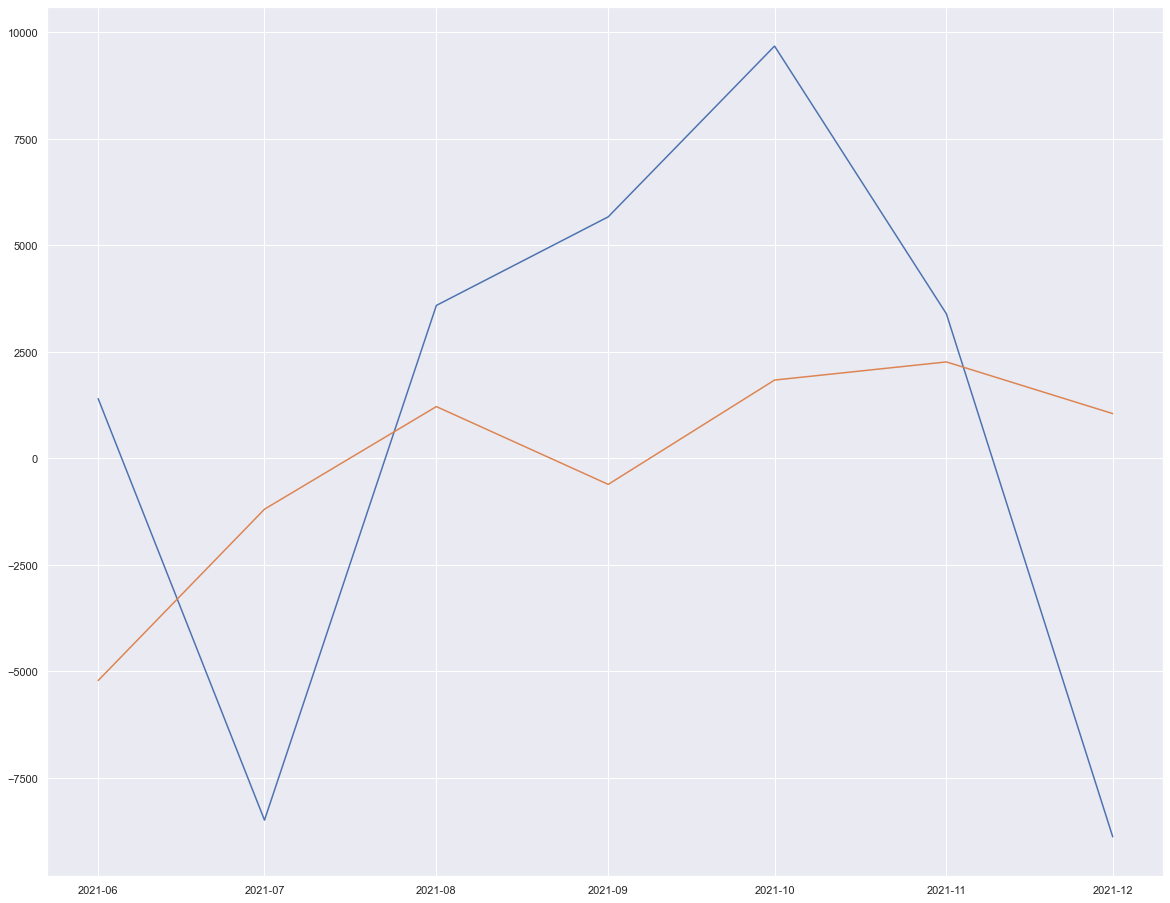

In [74]:
plt.figure(figsize=(20,16))
plt.plot(subplot)

This is the same as above with future 3 month predictions

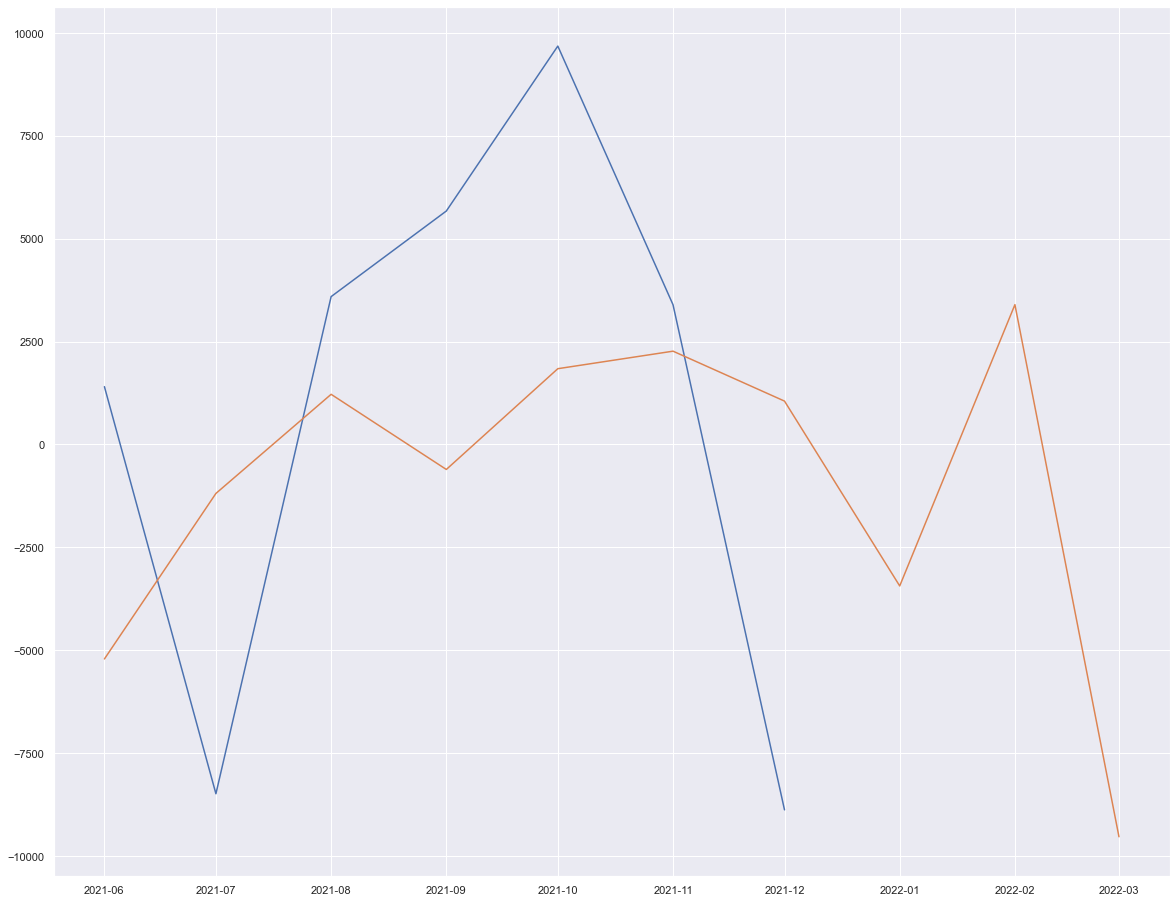

In [75]:
# baseplot = plt.plot
extended_subplot = pd.concat([adjusted_superframe['Retail sales, total'].tail(n=7),extended_forecast_df])
plt.figure(figsize=(20,16))
plt.plot(extended_subplot)

In [76]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  353
Model:             SARIMAX(0, 0, 2)x(1, 0, [], 12)   Log Likelihood               -3601.710
Date:                             Wed, 17 Aug 2022   AIC                           7213.421
Time:                                     16:04:51   BIC                           7232.753
Sample:                                          0   HQIC                          7221.114
                                             - 353                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1462.9231    346.871      4.217      0.000     783.069    2142.777
ma.L1         -0.1467      0.013    -11.599      0.000      -0.172      -0.122
ma.L2         -0.0903      0.017     -5.308      0.000      -0.124      -0.057
ar.S.L12      -0.2010      0.034     -5.968      0.000      -0.267      -0.135
sigma2      4.462e+07      0.027   1.68e+09      0.000    4.46e+07    4.46e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             29922.40
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              23.47   Skew:                             0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.66e+23. Standard errors may be unstable.
"""

In [77]:
actuallist = adjusted_superframe['Retail sales, total'].tail(n=7).to_list()
print(MAPE(actuallist,forecast[0]))
mape = mean_absolute_error(actuallist, forecast[0])
print(mape)

137.20902196293883
5923.941940521559


In [78]:
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# for i in adjusted_superframe:
#     plt.plot(adjusted_superframe[i])
plt.plot(adjusted_superframe['Retail sales, total'])
plt.title('Retail sales, total')
plt.ylabel('Sales ($1000)')
plt.xlabel('Date')
plt.grid(False)
plt.show()
# This plots all the variables

ModuleNotFoundError: No module named 'tqdm'

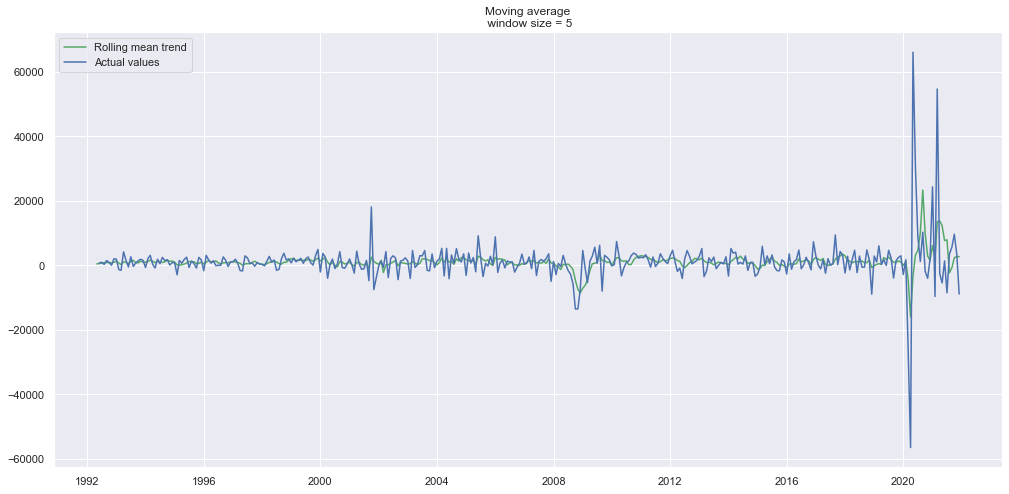

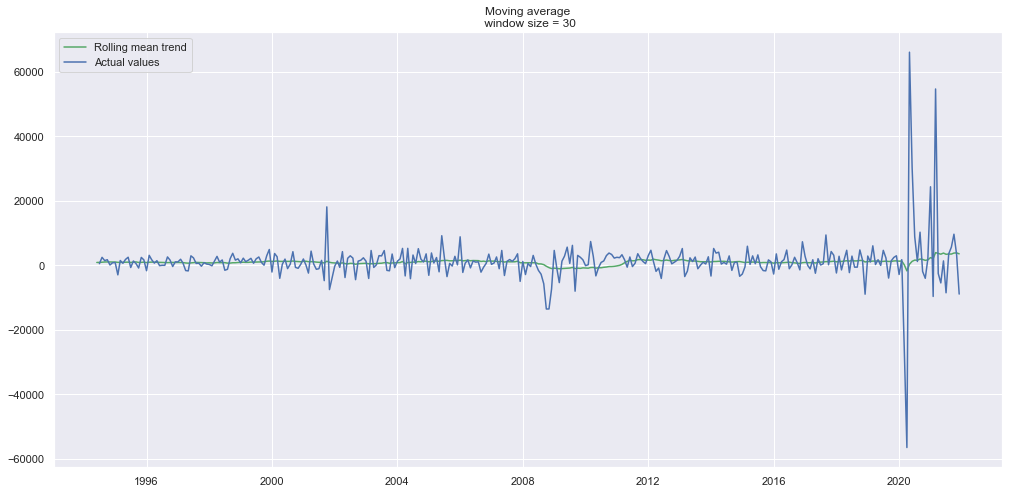

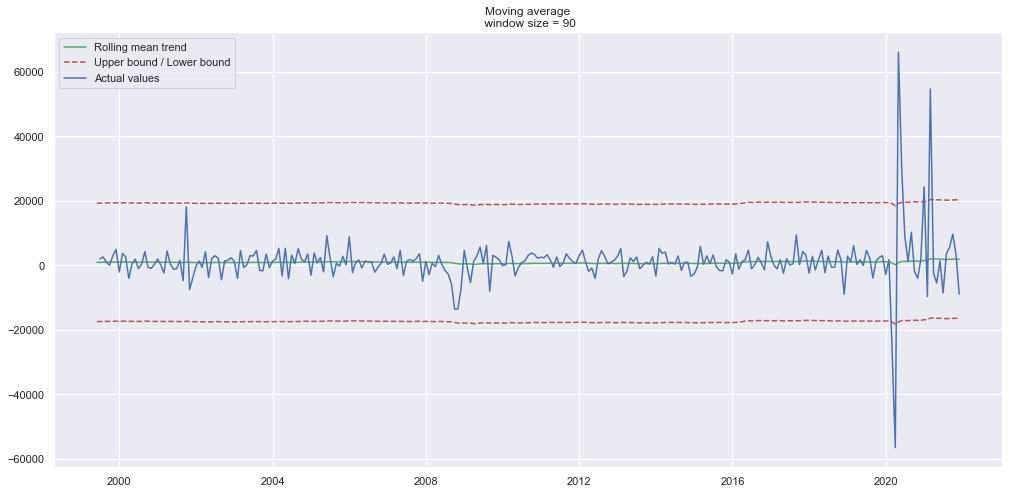

In [ ]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(adjusted_superframe['Retail sales, total'], 5)

#Smooth by the previous month (30 days)
plot_moving_average(adjusted_superframe['Retail sales, total'], 30)

#Smooth by previous quarter (90 days)
plot_moving_average(adjusted_superframe['Retail sales, total'], 90, plot_intervals=True)

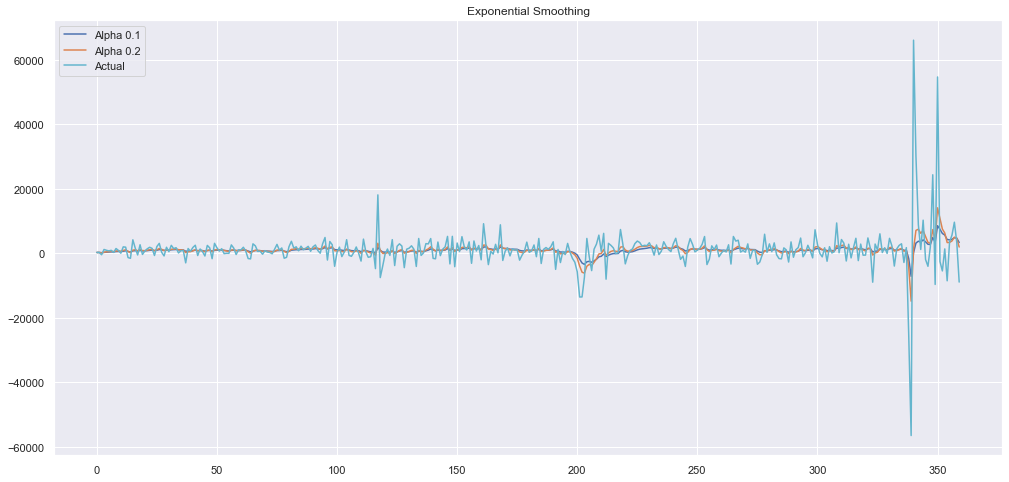

In [ ]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

plot_exponential_smoothing(adjusted_superframe['Retail sales, total'], [0.1, 0.2])

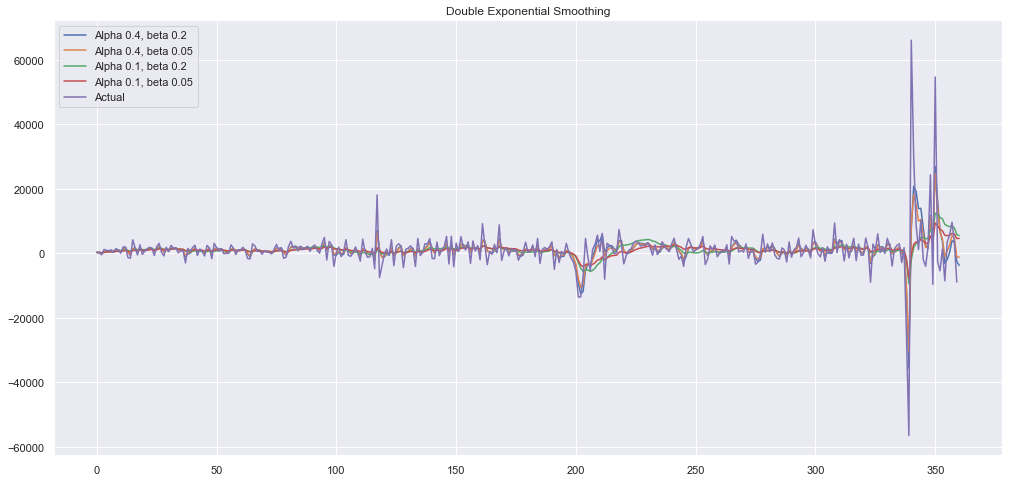

In [ ]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(adjusted_superframe['Retail sales, total'], alphas=[0.4, 0.1], betas=[0.2, 0.05])

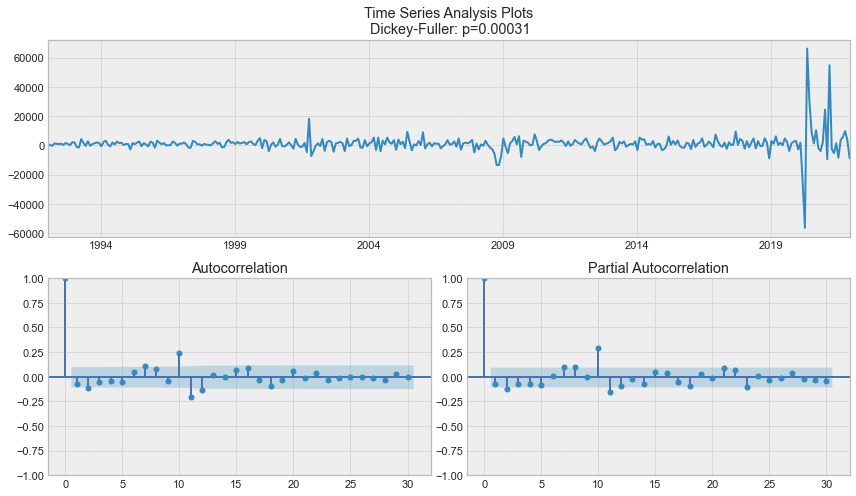

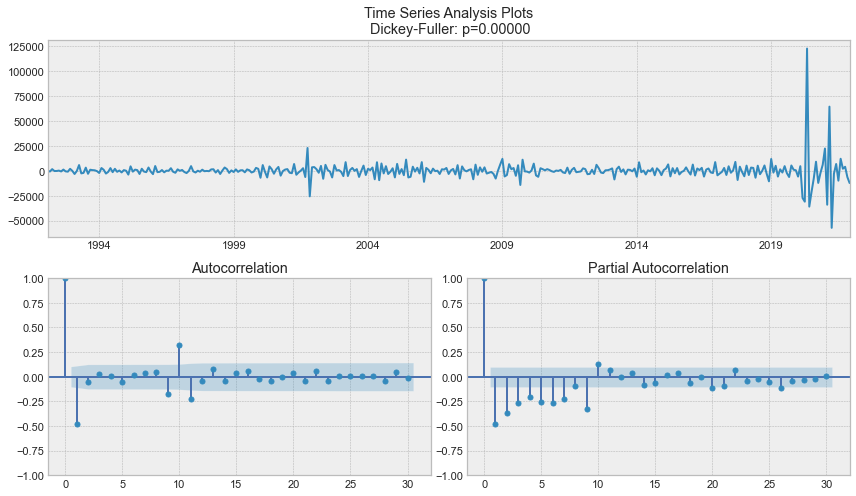

In [ ]:

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(adjusted_superframe['Retail sales, total'], lags=30)

# Take the first difference to remove to make the process stationary
data_diff = adjusted_superframe['Retail sales, total'] - adjusted_superframe['Retail sales, total'].shift(1)

tsplot(data_diff[1:], lags=30)

In [ ]:
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(adjusted_superframe['Retail sales, total'], order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(adjusted_superframe['Retail sales, total'], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

  0%|          | 0/625 [00:00<?, ?it/s]

                                     SARIMAX Results                                      
Dep. Variable:                Retail sales, total   No. Observations:                  360
Model:             SARIMAX(2, 1, 2)x(3, 1, [], 5)   Log Likelihood                   0.000
Date:                            Wed, 17 Aug 2022   AIC                             16.000
Time:                                    11:08:04   BIC                             46.954
Sample:                                01-01-1992   HQIC                            28.316
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0187         -0       -inf      0.000       0.019       0.019
ar.L2          0.9813         -0   

In [ ]:
forecast=best_model.get_prediction()
print(forecast)